# **Dataset**

In [1]:
#install Kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hendricoyehezky","key":"5e0f8e205c85eaf2fa1accc496ed0fa5"}'}

In [3]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets list -s 'covid 19 xray'

ref                                                                     title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/bachrr/covid-chest-xray                                        COVID-19 chest xray                             241MB  2020-05-15 00:30:50           9622        216  0.9411765        
datasets/khoongweihao/covid19-xray-dataset-train-test-sets              COVID-19 Xray Dataset (Train & Test Sets)        84MB  2020-03-19 01:49:56           5004        131  0.875            
datasets/fusicfenta/chest-xray-for-covid19-detection                    Chest Xray for covid-19 detection               176MB  2020-05-15 04:15:43            901         28  0.875            
datasets/alifrahman/covid19-chest-xray-i

In [8]:
!kaggle datasets download -d 'khoongweihao/covid19-xray-dataset-train-test-sets'

 87% 73.0M/84.3M [00:01<00:00, 46.3MB/s]
100% 84.3M/84.3M [00:01<00:00, 50.0MB/s]


In [9]:
!unzip /content/covid19-xray-dataset-train-test-sets.zip

Archive:  /content/covid19-xray-dataset-train-test-sets.zip
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0035-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0052-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0058-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0059-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0072-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0073-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0092-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0105-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0110-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0111-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0112-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0117-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL

# **Moduls**

In [10]:
import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
import pandas as pd
import os
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from skimage import transform, io
from torchvision import transforms,utils
import matplotlib.pyplot as plt
from glob import glob
from itertools import chain
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import torch.backends.cudnn as cudnn 
import torch.optim as optim
%matplotlib inline
import os, sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
from keras.models import load_model
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

In [11]:
# Lokasi Data Train
DATA_PATH = '/content/xray_dataset_covid19/train'
COVID_PATH = '/content/xray_dataset_covid19/train/PNEUMONIA'
NORMAL_PATH = '/content/xray_dataset_covid19/train/NORMAL'

# **EVDA**

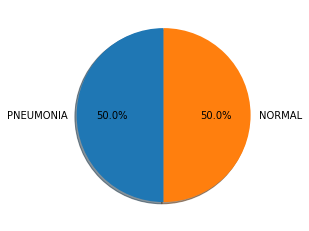

In [12]:
# Pengecekan Balancing Data
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(class_names)

#Plot diagram jumlah data kelas Pnunomia dan Normal
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

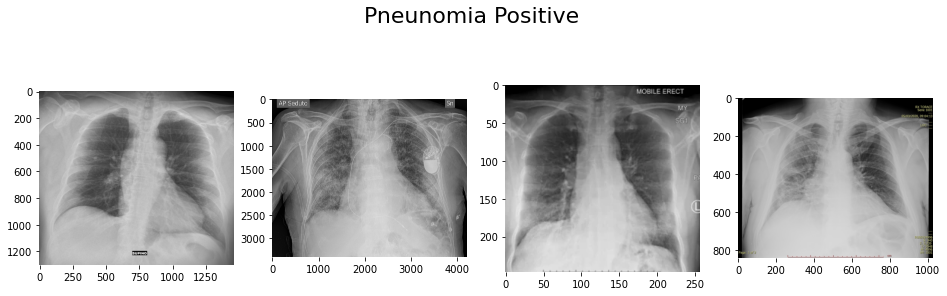

In [13]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("Pneunomia Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

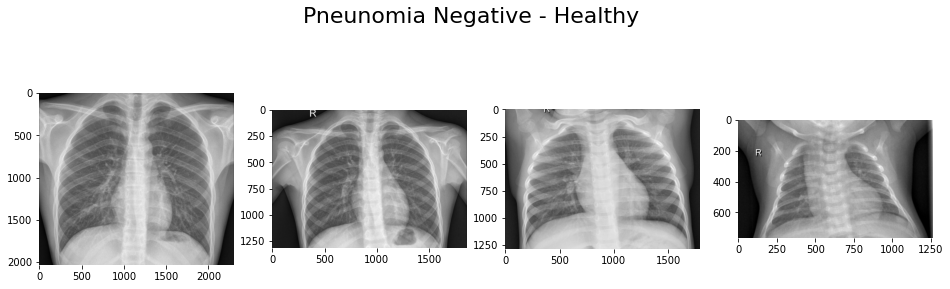

In [14]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("Pneunomia Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [15]:
#Data Transform
#Normalisasi data image training
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Membuat data image ke dalam dimensi 150×150
                                transforms.RandomRotation(10), # Rotasi gambar dengan derajat maksimum 10 derajat
                                transforms.RandomHorizontalFlip(p=0.4), #Memutar balik gambar secara horizontal sebanyak 40%
                                transforms.ToTensor(), # Mengubah data image ke dalam tensor
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalisasi
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Membuat data menjadi terpusat dengan dimensi 150×150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [16]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Mengambil gambar dalam data train dan memberi label
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Pemisahan data training yang sudah diolah dan diproses validasinya
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # Data yang sudah diolah disimpan dalam sampler size sebanyak 8 per sample
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['NORMAL', 'PNEUMONIA']


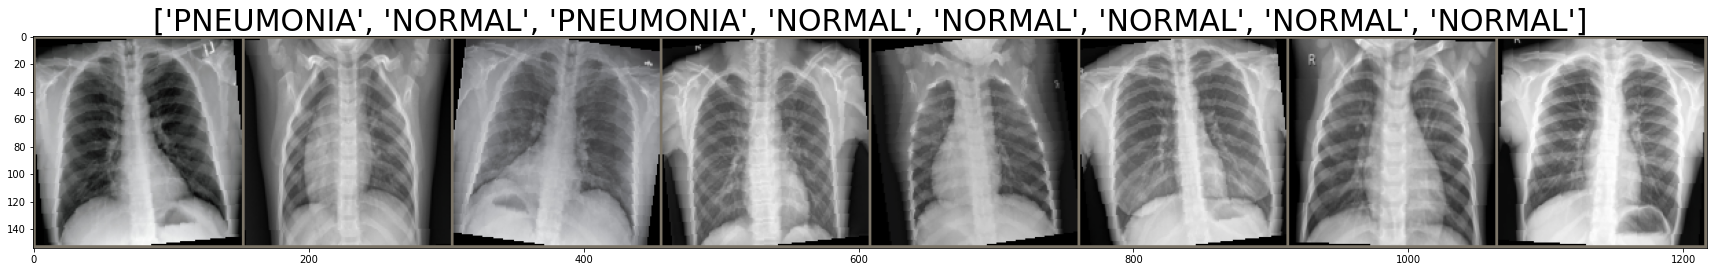

In [17]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # Fitur pause per 0,001 detik per update


# Mengambil 8 batch data training
inputs, classes = next(iter(dataloaders['train']))

# Membuat skala grid untuk ke-8 data train yang diambil
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# **Modul X-Net**

In [27]:
#DEFINE THE NETWORK
class Xnet(nn.Module):
  def __init__(self):
    super(Xnet,self).__init__() 
    self.conv1 = nn.Conv2d(1,64,kernel_size = 3, padding = 1)                     #1 x 256 x 256 > 64 x 256 x 256
    self.batch_norm1 = nn.BatchNorm2d(64)                                         #BN1 = 64                                                
    self.pool = nn.MaxPool2d(2,2)                                                 # 64 x 128 x 128 
    self.conv2 = nn.Conv2d(64,128, kernel_size =3, padding =1)                    # 128 x 128 x 128
    self.batch_norm2 = nn.BatchNorm2d(128)                                        # bn2 = 128
    self.conv3 = nn.Conv2d(128,256, kernel_size = 3, padding = 1)                 # 256 x 128 x 128
    self.batch_norm3 = nn.BatchNorm2d(256) 
    self.conv4 = nn.Conv2d(256,512, kernel_size = 3, padding = 1)
    self.batch_norm4 = nn.BatchNorm2d(512) 
    self.conv5 = nn.Conv2d(512,512, kernel_size = 3, padding = 1)
    self.conv6 = nn.Conv2d(512,256, kernel_size = 3, padding = 1)
    self.conv7 = nn.Conv2d(256,128, kernel_size = 3, padding = 1)
    self.conv8 = nn.Conv2d(128,128,kernel_size = 3, padding = 1)
    self.conv9 = nn.Conv2d(128,256,kernel_size = 3, padding = 1)
    self.conv10 = nn.Conv2d(256, 512, kernel_size = 3, padding =1)
    self.conv11 = nn.Conv2d(512,512, kernel_size = 3, padding = 1)
    self.conv12 = nn.Conv2d(512,256, kernel_size = 3, padding = 1)
    self.conv13 = nn.Conv2d(256,128, kernel_size = 3, padding = 1)
    self.conv14 = nn.Conv2d(128,64, kernel_size =3, padding = 1)
    self.conv15 = nn.Conv2d(64, number_of_classes, kernel_size = 1)
    self.fc1 = nn.Linear(13*256*256, 64)
    self.fc2 = nn.Linear(64, number_of_classes)
    
  def forward(self, x):
    act1 = F.relu(self.batch_norm1(self.conv1(x)))          #64 x 256 x 256
    x = self.pool(act1)                                     #64 x 128 x 128
    act2 = F.relu(self.batch_norm2(self.conv2(x)))          #128 x 128 x 128
    x = self.pool(act2)                                     #128 x 64 x 64
    act_3 = F.relu(self.batch_norm3(self.conv3(x)))         #256 x 64 x 64
    x = self.pool(act_3)                                    #256 x 32 x 32
    x = F.relu(self.batch_norm4(self.conv4(x)))   #512 x 32 x 32
    x = F.relu(self.batch_norm4(self.conv5(x)))   #512 x 32 x 32
    x = F.upsample(x, size = 64)   #6
    x = F.relu(self.batch_norm3(self.conv6(x)))   #256 x 64 x 64    
    x = x.add(act_3)    
    x = F.upsample(x, size = 128)                 #256 x 128 x 128
    x = F.relu(self.batch_norm3(self.conv7(x)))   #128 x 128 x 128
    x = x.add(act2)    
    act_8 = F.relu(self.batch_norm2(self.conv8(x))) #128 x 128 x 128
    x = self.pool(act_8)                            #128 x 64 x 64
    act_9 = F.relu(self.batch_norm3(self.conv9(x))) #256 x 64 x 64
    x = self.pool(act_9)                            #256 x 32 x 32
    x = F.relu(self.batch_norm4(self.conv10(x)))    #512 x 32 x 32
    x = F.relu(self.batch_norm4(self.conv11(x)))    #512 x 32 x 32    
    x = F.upsample(x, size = 64)                    #512 x 64 x 64
    x = F.relu(self.batch_norm3(self.conv12(x)))    #256 x 64 x 64
    x = x.add(act_9)    
    x = F.upsample(x, size = 128)                   #256 x 128 x 128 
    x = F.relu(self.batch_norm2(self.conv13(x)))    #128 x 128 x 128
    x = x.add(act_8)    
    x = F.upsample(x, size = 256)                   #128 x 256 x 256
    x = F.relu(self.batch_norm1(self.conv14(x)))    #64 x 256 x 256
    x = x.add(act1)
    x = self.conv15(x)                              #13 x 256 x 256
    x = x.view(-1,13*256*256)
    x = F.relu(self.fc1(x))
    x = nn.Sigmoid(self.fc2(x))
    return x

In [31]:
def Xnet_Model(pretrained=True):
    model = Xnet() # model dengan bobot data train di dalam modul Xnet
    num_ftrs = 2 # Jumlah fitur kelas dalam Xnet
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Perubahan fitur kelas dalam Xnet dalam proses pembelajaran
    return model

model = Xnet_Model()

# Fungsi Loss(categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Optimasi performansi dengan regulator gradient descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Peluruhan Learning Rate dengan faktor 0.1/7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Fase Training dan Validation per epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Pengaturan model training
            else:
                model.eval()   # Pengaturan model evaluasi

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to()
                labels = labels.to()

                # Optimasi untuk mendapatkan gradien = 0
                optimizer.zero_grad()

                # Proses log pada status loss dalam fase training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize dalam fase training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # Akurasi pada statistik Fungsi Loss
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # Fase Stop
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to()
            labels = labels.to()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [34]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3252 | train Accuracy: 0.8739


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.1285 | val Accuracy: 0.9310 | Kappa Score: 0.8462
Val loss Decreased from inf to 0.1285 
Saving Weights... 

Epoch 2/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1086 | train Accuracy: 0.9496


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0701 | val Accuracy: 0.9310 | Kappa Score: 0.8750
Val loss Decreased from 0.1285 to 0.0701 
Saving Weights... 

Epoch 3/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.0627 | train Accuracy: 0.9748


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0597 | val Accuracy: 1.0000 | Kappa Score: 1.0000
Val loss Decreased from 0.0701 to 0.0597 
Saving Weights... 

Epoch 4/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2140 | train Accuracy: 0.9244


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0613 | val Accuracy: 0.9655 | Kappa Score: 0.8864

Epoch 5/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1901 | train Accuracy: 0.9328


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0527 | val Accuracy: 1.0000 | Kappa Score: 1.0000
Val loss Decreased from 0.0597 to 0.0527 
Saving Weights... 

Epoch 6/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1492 | train Accuracy: 0.9664


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0526 | val Accuracy: 1.0000 | Kappa Score: 1.0000
Val loss Decreased from 0.0527 to 0.0526 
Saving Weights... 

Epoch 7/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1524 | train Accuracy: 0.9244


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0567 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 8/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1998 | train Accuracy: 0.9412


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0548 | val Accuracy: 1.0000 | Kappa Score: nan

Epoch 9/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.0987 | train Accuracy: 0.9664


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0673 | val Accuracy: 0.9655 | Kappa Score: 0.9375

Epoch 10/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.0996 | train Accuracy: 0.9664


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0648 | val Accuracy: 0.9655 | Kappa Score: 0.9286

Epoch 11/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1498 | train Accuracy: 0.9412


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0567 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 12/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2001 | train Accuracy: 0.9496


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0673 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 13/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1299 | train Accuracy: 0.9580


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0613 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 14/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1128 | train Accuracy: 0.9664


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0594 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 15/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2402 | train Accuracy: 0.9244


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0465 | val Accuracy: 1.0000 | Kappa Score: 1.0000
Val loss Decreased from 0.0526 to 0.0465 
Saving Weights... 

Epoch 16/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1288 | train Accuracy: 0.9412


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0481 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 17/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1553 | train Accuracy: 0.9496


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0536 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 18/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2911 | train Accuracy: 0.8992


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0569 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 19/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.0901 | train Accuracy: 0.9748


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0648 | val Accuracy: 0.9655 | Kappa Score: 0.9286

Epoch 20/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2771 | train Accuracy: 0.9076


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0553 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Training complete in 7m 13s
Best val loss: 0.0465


# **Visualisasi Hasil Training**

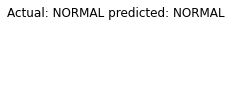

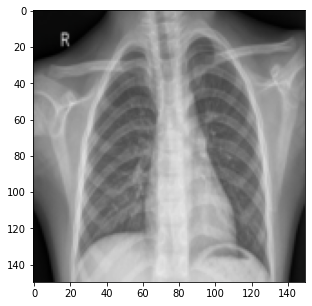

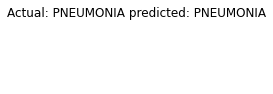

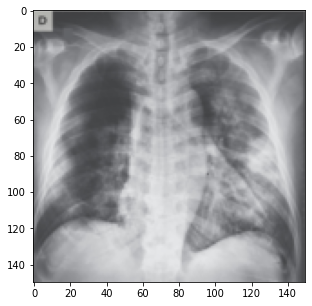

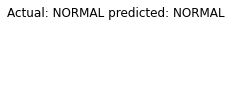

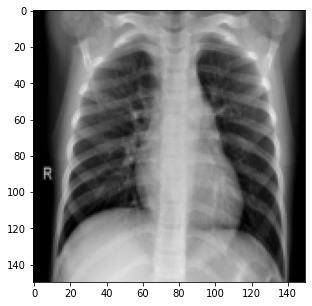

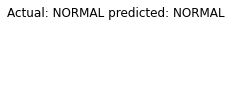

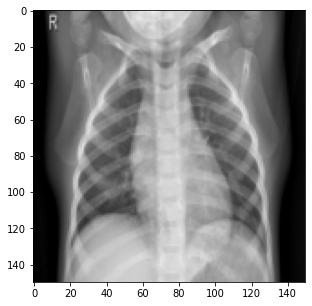

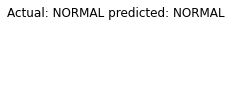

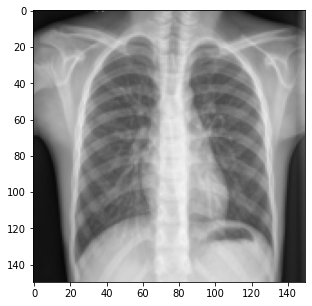

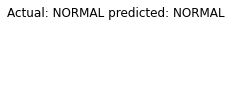

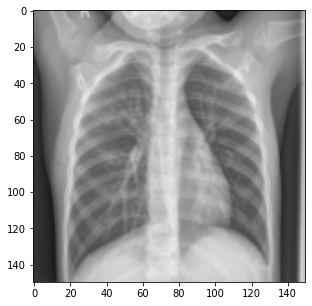

In [35]:
visualize_model(base_model)
plt.show()

# **Evaluasi hasil Prediksi X-Net**

In [36]:
os.makedirs('./content/xray_dataset_covid19/test/PNEUMONIA')
os.makedirs('./content/xray_dataset_covid19/test/NORMAL')

In [37]:
TEST_DATA_PATH = '/content/xray_dataset_covid19/test/'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [38]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(), y_batch.to()
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/40 [00:00<?, ?it/s]

In [39]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [40]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



In [41]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

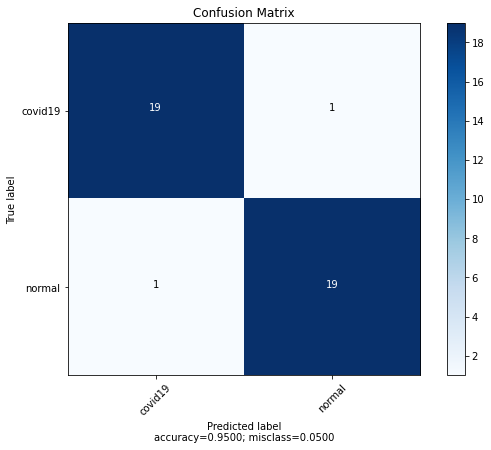

In [42]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [44]:
torch.save(base_model.state_dict(), './best_model.pth')

# **Inferensi (Simulasi Prediksi)**

In [45]:
# Loading the model pre-trained weights from saved file
inf_model = CNN_Model(pretrained=False)
inf_model.to(torch.device('cpu'))
inf_model.load_state_dict(torch.load('./best_model.pth', map_location='cpu'))
inf_model.eval()
print('Inference Model Loaded on CPU')

Inference Model Loaded on CPU


In [46]:
import cv2
from torch.autograd import Variable

In [48]:
# Fungsi Inferensi
def predict(img_path):
    image = Image.open(img_path)
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cpu'))
    out = inf_model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    print("Predicted: {}".format(pred_class))

# **Prediksi #1**

Predicted: PNEUMONIA


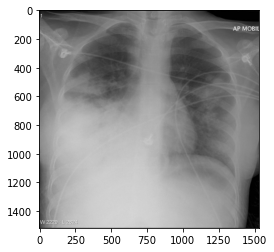

In [49]:
predict('/content/xray_dataset_covid19/test/PNEUMONIA/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day0.jpg')

# **Prediksi #2**

Predicted: PNEUMONIA


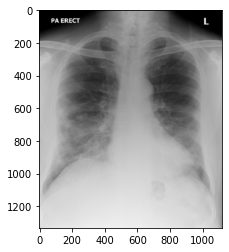

In [50]:
predict('/content/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day0.jpeg')